### Monte Carlo Option Pricing
https://www.tejwin.com/en/insight/options-pricing-with-monte-carlo-simulation/

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm


### We need to simulate the underlying stock path first
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

Consider 
$$
y = ln(S_t) \\

y' = \frac{1}{S_t} ; y'' = -\frac{1}{S_t^2}
$$
Now do Ito's Lemma
$$
 dy = y'dS_t + y''(dS_t)^2 \\
 = \frac{1}{S_t} (\mu S_t dt + \sigma S_t dW_t) - \frac{1}{2} * \frac{1}{S_t^2} (\sigma ^2 S_t ^2 dt) \\
 d(ln(S_t))= (\mu dt + \sigma dW_t) - 0.5 \sigma ^2 dt
$$

You can solve this but why not do this
$$
d(ln(S_t))= ln(S_{t+\Delta t}) - ln(S_{t})
$$

Therefore
$$
ln(S_{t+\Delta t}) = ln(S_{t}) + (\mu - 0.5 \sigma ^2 ) dt + \sigma dW_t
$$

Later to find $S_t$ just do a exponential!

In [181]:
sigma = 0.1 # vol underlying
r = 0.5 # rfr
q = 0.3 # dividend
S0 = 100 # init price underlying
T = 1.0 # time in years
N = 100 # timesteps for dt
M = 100 # how many paths?

In [182]:
# compute stuff 
dt = T/N
mudt = (r - q - 0.5 * sigma**2) * dt
vol_norm = sigma * np.sqrt(dt)
lnS = np.log(S0)
print(lnS)

4.605170185988092


In [183]:
Z = np.random.normal(size = (M,N))


In [184]:
# do the randnumber, try with numpy first M * N, i.e. N timesteps for each of the M paths

def generateGBMStock(S0, sigma, r, q, Z):
    dt = T/N
    mudt = (r - q - 0.5 * sigma**2) * dt
    vol_norm = sigma * np.sqrt(dt)
    lnS = np.log(S0)
    deltaZ = vol_norm * Z
    deltaLnS = mudt + deltaZ
    cumsumMatrix = np.cumsum(deltaLnS,axis = 1) # awas salah axis goblok
    cumsumMatrix = np.c_[np.zeros(M), cumsumMatrix]
    lnSMatrix = lnS + cumsumMatrix
    priceMatrix = np.exp(lnSMatrix)
    return priceMatrix

In [185]:
result_np_random = generateGBMStock(S0, sigma, r, q, Z)

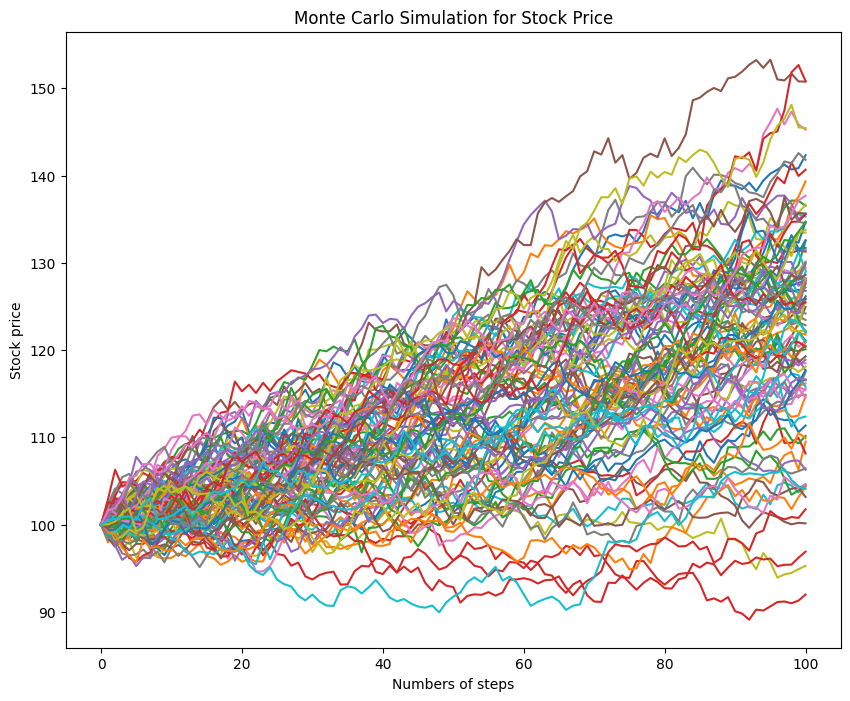

In [186]:
plt.figure(figsize = (10,8))
for i in range(len(result_np_random)):
    plt.plot(result_np_random[i])
plt.xlabel('Numbers of steps')
plt.ylabel('Stock price')
plt.title('Monte Carlo Simulation for Stock Price')
plt.show()

## Let us use Sobol

Faster rate of convergence apparently
https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method

In [187]:
sobol = qmc.Sobol(d=N, scramble=True).random(M)
Z_from_sobol = norm.ppf(sobol)


/home/kilo/.local/lib/python3.10/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [188]:
result_np_qmc = generateGBMStock(S0, sigma, r, q, Z_from_sobol)

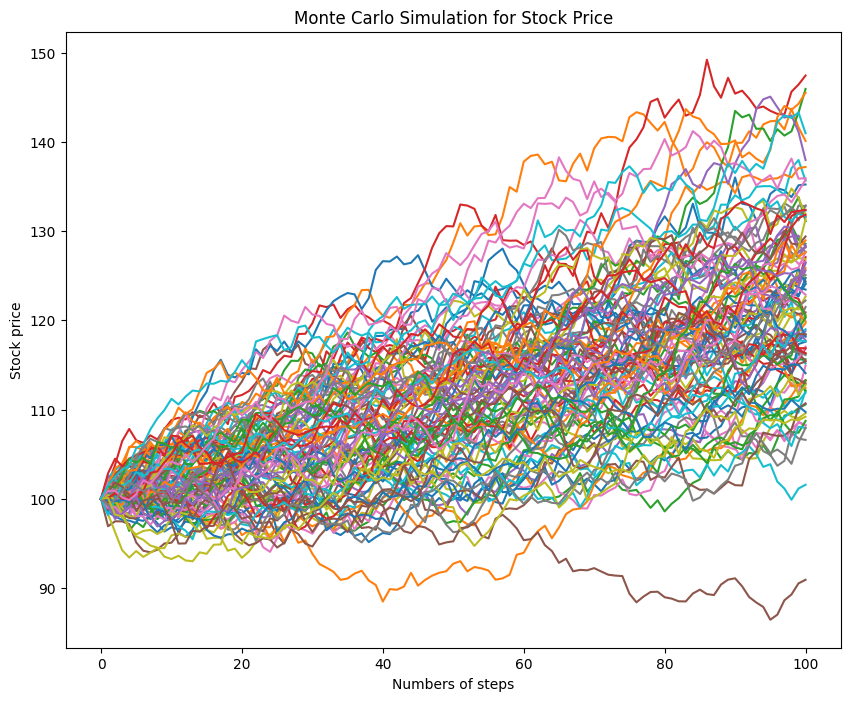

In [189]:
plt.figure(figsize = (10,8))
for i in range(len(result_np_qmc)):
    plt.plot(result_np_qmc[i])
plt.xlabel('Numbers of steps')
plt.ylabel('Stock price')
plt.title('Monte Carlo Simulation for Stock Price')
plt.show()

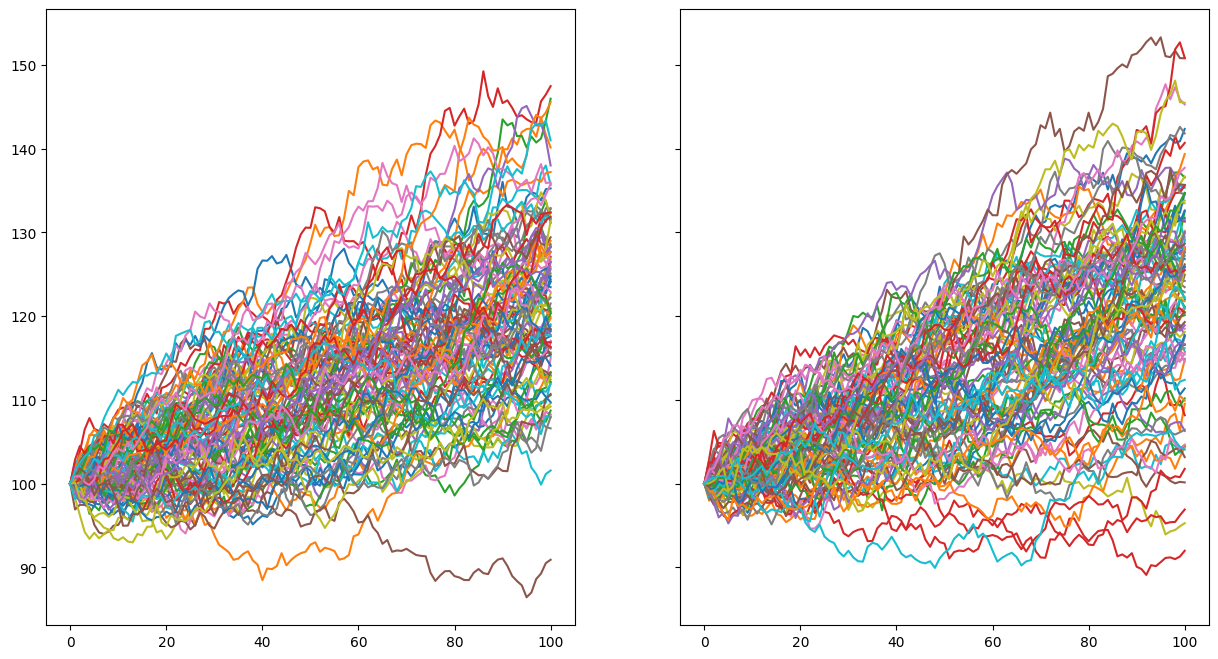

In [190]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8))
for i in range(len(result_np_qmc)):
    ax1.plot(result_np_qmc[i])
for i in range(len(result_np_random)):
    ax2.plot(result_np_random[i])